In [1]:
import geopandas as gpd

In [2]:
# read in the demographic variables
to_dems = gpd.read_file('toronto_census_all.shp')

# rename the columns that were auto-shortened
to_dems.rename(columns = {'Percentage': 'Percentage of visible minority',
                           'Median tot': 'Median total income of households in 2020 ($)',
                             'Homeowners':'Homeownership rate (%)'}, inplace=True)

# read in the isochrone variables
to_isos = gpd.read_file('./isochrones_final/isochrones_change_final.shp')

# isolate out geometry and rename columns auto-shortened on last save
isos_df = to_isos[['DGUID', '30_change', '15_change', '30_2015', '30_2025', '15_2015', '15_2025', '15_increas', '30_increas']].rename(
    columns = {'15_increas': '15_increase', '30_increas': '30_increase'})

# merge - MUST be a "right" merge to account for slivers in left dataset!
to_all = to_dems.merge(isos_df.interpolate(), how = 'right', on = 'DGUID')

# this is the ultimate clean total variable shapefile for analysis, save so bivariate can access
to_all.to_file('to_all_variables_for_cluster_analysis.shp')

C:\Users\saman\AppData\Local\Temp\ipykernel_35060\3657474659.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  to_all = to_dems.merge(isos_df.interpolate(), how = 'right', on = 'DGUID')
C:\Users\saman\AppData\Local\Temp\ipykernel_35060\3657474659.py:20: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  to_all.to_file('to_all_variables_for_cluster_analysis.shp')
C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Percentage of visible minority' to 'Percentage'
  ogr_write(
C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized

In [3]:
import esda
import libpysal as lps

# project
to_all = to_all.to_crs('epsg:3857')

# create weight matrix. Queen contiguity most appropriate given shapes of census tracts
w = lps.weights.Queen.from_dataframe(to_all, use_index=False)

In [4]:
# Global Moran's I Stuff
VMmoransi = esda.Moran(to_all['Percentage of visible minority'], w)
MMHHmoransi = esda.Moran(to_all['Median total income of households in 2020 ($)'], w)
HORmoransi = esda.Moran(to_all['Homeownership rate (%)'],w)
HORmoransi = esda.Moran(to_all['30_change'],w)
iso_30_change_moransi = esda.Moran(to_all['30_change'], w)
iso_30_increase_moransi = esda.Moran(to_all['30_increase'], w)

print(f'The Morans I value for VM is {VMmoransi.I}')
print(f'The Morans I value for MMHH is {MMHHmoransi.I}')
print(f'The Morans I value for HOR is {HORmoransi.I}')
print(f'The Morans I value for 30_change is {iso_30_change_moransi.I}')
print(f'The Morans I value for 30_increase is {iso_30_increase_moransi.I}')

print(f'The p-value for VM is {VMmoransi.p_sim}')
print(f'The p-value for MMHH is {MMHHmoransi.p_sim}')
print(f'The p-value for 30_change is {iso_30_change_moransi.p_sim}')
print(f'The p-value for 30_increase is {iso_30_increase_moransi.p_sim}')


The Morans I value for VM is 0.5254431786444961
The Morans I value for MMHH is 0.4636222078534422
The Morans I value for HOR is 0.45221445568566077
The Morans I value for 30_change is 0.45221445568566077
The Morans I value for 30_increase is 0.33075158550458744
The p-value for VM is 0.001
The p-value for MMHH is 0.001
The p-value for 30_change is 0.001
The p-value for 30_increase is 0.001


In [5]:
# get the local moran's I graphs for relevant columns

MMHHmorans_local = esda.Moran_Local(to_all['Median total income of households in 2020 ($)'], w)
HORmorans_local = esda.Moran_Local(to_all['Homeownership rate (%)'], w)
VMmorans_local = esda.Moran_Local(to_all['Percentage of visible minority'], w)
iso_30_change_local = esda.Moran_Local(to_all['30_change'], w)
iso_30_increase_local = esda.Moran_Local(to_all['30_increase'], w)

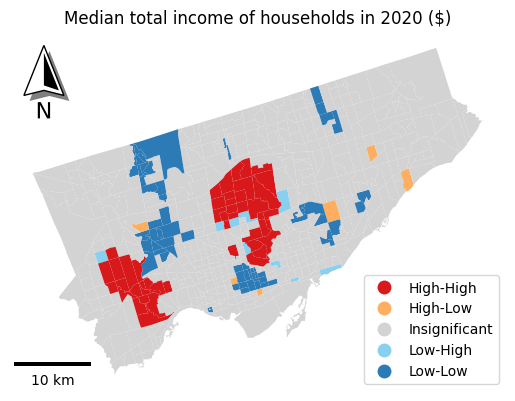

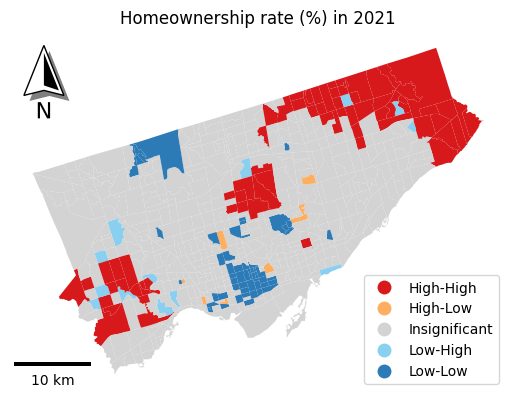

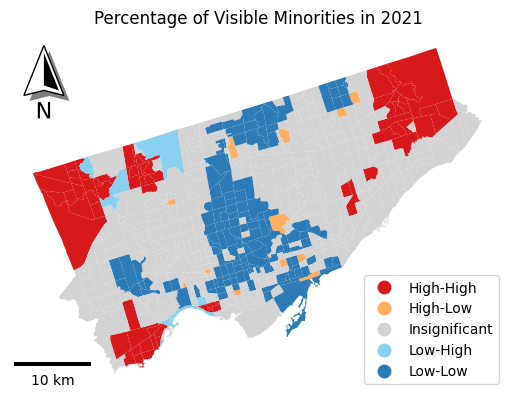

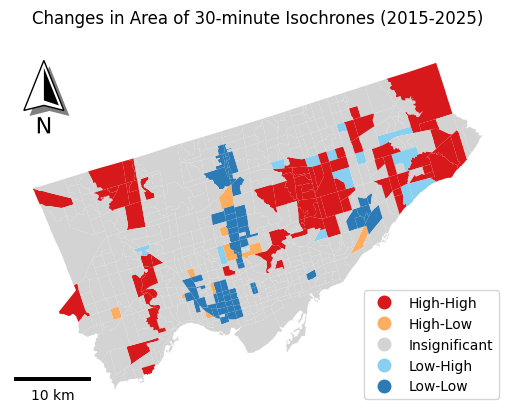

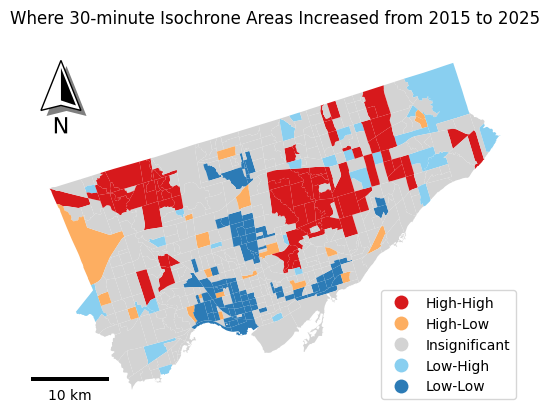

In [6]:
# look at them!

from plotter import plot_local_moran
    
f1, ax = plot_local_moran(MMHHmorans_local, to_all, 'Median total income of households in 2020 ($)')
f2, ax = plot_local_moran(HORmorans_local, to_all, 'Homeownership rate (%) in 2021')
f3, ax = plot_local_moran(VMmorans_local, to_all, 'Percentage of Visible Minorities in 2021')
f4, ax = plot_local_moran(iso_30_change_local, to_all, 'Changes in Area of 30-minute Isochrones (2015-2025)')
f5, ax = plot_local_moran(iso_30_increase_local, to_all, 'Where 30-minute Isochrone Areas Increased from 2015 to 2025')


In [7]:
f1.savefig('Median Income Local Moran Figure.png')
f2.savefig('Homeownership rate (%) in 2021 Local Moran Figure.png')
f3.savefig('Percentage of Visible Minorities in 2021 Local Moran Figure.png')
f4.savefig('Changes in Area of 30-minute Isochrones (2015-2025) Local Moran Figure.png')
f5.savefig('Where 30-minute Isochrone Areas Increased from 2015 to 2025 Local Moran Figure.png')